<a href="https://colab.research.google.com/github/Dearsu520/automotive-modeling-project/blob/model/Model/Price_Prediction_RandomForest_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
path = "/content/drive/MyDrive/Data Bootcamp Final Project/model_df.zip"
df = pd.read_csv(path, index_col=0)

In [ ]:
# Import Dependencies
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Feature Selection
from sklearn.feature_selection import RFE

# Model Selection and Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics and Scores
from sklearn.metrics import r2_score


In [ ]:
df

,price,manufacturer,car_model,year,title_status,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,region,state,lat,long
date,,,,,,,,,,,,,,,,,
2020-12-02 14:11:30+00:00,35990,chevrolet,corvette,2010.0,clean,good,8.0,gas,32742.0,other,rwd,other,not specified,auburn,al,32.590000,-85.480000
2020-12-02 08:11:50+00:00,7500,hyundai,sonata,2014.0,clean,excellent,4.0,gas,93600.0,automatic,fwd,sedan,not specified,auburn,al,32.547500,-85.468200
2020-12-02 01:50:41+00:00,4900,bmw,x3,2006.0,clean,good,6.0,gas,87046.0,automatic,not specified,SUV,blue,auburn,al,32.616807,-85.464149
2020-12-01 21:54:45+00:00,2000,chevrolet,c10,1974.0,clean,good,4.0,gas,190000.0,automatic,rwd,pickup,blue,auburn,al,32.861600,-85.216100
2020-12-01 13:27:25+00:00,29590,toyota,tacoma,2016.0,clean,good,6.0,gas,33290.0,other,not specified,pickup,red,auburn,al,32.590000,-85.480000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-03 15:06:21+00:00,19950,audi,a4,2017.0,clean,not specified,NaN,gas,101270.0,automatic,not specified,other,not specified,wausau,wi,44.843195,-91.550371
2020-12-03 14:56:29+00:00,14995,cadillac,srx,2014.0,clean,excellent,6.0,gas,83790.0,automatic,4wd,SUV,silver,wausau,wi,44.408867,-89.881210
2020-12-03 14:48:08+00:00,17895,hyundai,tucson,2018.0,clean,excellent,4.0,gas,31888.0,automatic,4wd,SUV,white,wausau,wi,44.408867,-89.882240


In [ ]:
df.dtypes

price             int64
manufacturer     object
car_model        object
year            float64
title_status     object
condition        object
cylinders       float64
fuel             object
odometer        float64
transmission     object
drive            object
type             object
paint_color      object
region           object
state            object
lat             float64
long            float64
dtype: object

In [ ]:
df.isnull().sum()

price                0
manufacturer         0
car_model            6
year                 3
title_status      1302
condition            0
cylinders       108726
fuel                 0
odometer             0
transmission         0
drive                0
type                 0
paint_color          0
region               0
state                0
lat               2309
long              2309
dtype: int64

In [ ]:
df.shape

(324626, 17)

# Preprocessing 

- X is all features except price column, y is price column as we are targeting to predict price.

- Most of nan values from original data set were already removed during transformation process.

### Remove outliers based on each feature's threshold

***Price***

- As we see in the plot below, price (our target) has a lot of outliers, they will be removed based on the thresholds.



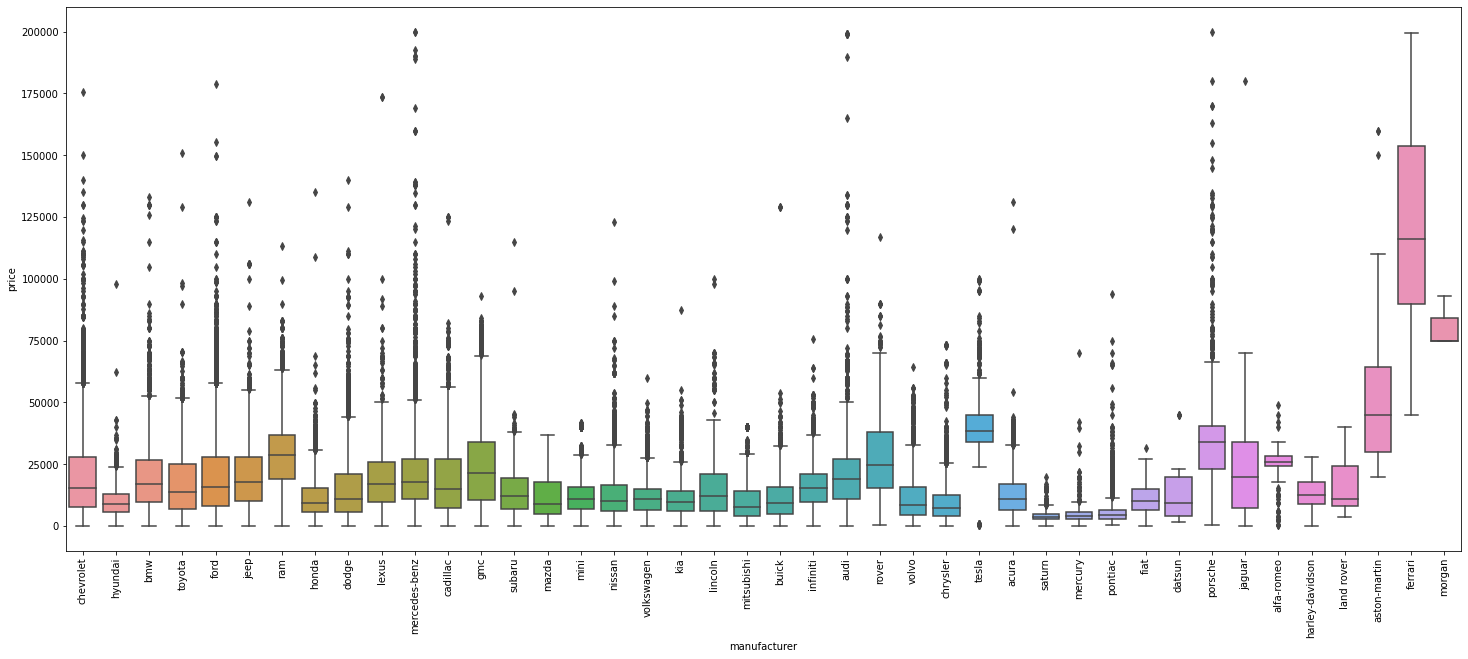

In [ ]:
# Remove outliers based on price column
# Plot car price to identify outliers
plt.figure(figsize=(25,10))
sns.boxplot(x='manufacturer'  , y='price'  , data=df)
plt.xticks(rotation=90)
plt.savefig('pricevsmanufacturer.png')

In [ ]:
manufactures = df['manufacturer'].unique()

arrays = []

# Calculate interquartile range(IRQ) of price for each manufacturer
for m, manufacturer in enumerate(manufactures):
  df_manufacturer = df[df['manufacturer'] == manufacturer ]
  Q1 = df_manufacturer['price'].quantile(0.25)
  Q3 = df_manufacturer['price'].quantile(0.75)
  IQR = Q3 - Q1
  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR

  # Filter out price range between (Q1 - 1.5 * IQR) and (Q3 + 1.5 * IQR) for each manufacturer

  new_df = 'updated' + str(manufacturer)
  new_df = df_manufacturer[((df_manufacturer['price'] > lower_limit) & (df_manufacturer['price'] < upper_limit))]

  array = new_df.values
  arrays.append(array)

In [ ]:
new_df = pd.DataFrame(np.concatenate(arrays))
new_df.columns = ['price', 'manufacturer','car_model', 'year', 'title_status', 'condition', 'cylinders', 'fuel', 'odometer', 'transmission', 'drive', 'type','paint_color','region', 'state', 'lat', 'long']
new_df.reset_index(drop=True, inplace=True)

In [ ]:
new_df

,price,manufacturer,car_model,year,title_status,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,region,state,lat,long
0,35990,chevrolet,corvette,2010,clean,good,8,gas,32742,other,rwd,other,not specified,auburn,al,32.59,-85.48
1,2000,chevrolet,c10,1974,clean,good,4,gas,190000,automatic,rwd,pickup,blue,auburn,al,32.8616,-85.2161
2,41990,chevrolet,camaro,2012,clean,good,8,gas,2778,other,rwd,coupe,red,auburn,al,32.59,-85.48
3,33990,chevrolet,corvette,2012,clean,good,8,gas,49245,automatic,rwd,other,white,auburn,al,32.59,-85.48
4,40590,chevrolet,camaro,2013,clean,good,8,gas,7007,other,rwd,other,orange,auburn,al,32.59,-85.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318414,89995,ferrari,360,2002,clean,not specified,NaN,gas,27110,manual,rwd,coupe,silver,madison,wi,43.0631,-89.3133
318415,89999,ferrari,california,2010,clean,not specified,NaN,gas,29000,automatic,not specified,other,not specified,SF bay area,ca,38.5259,-121.343
318416,74977,morgan,plus,2002,clean,excellent,8,gas,2379,manual,rwd,other,silver,ft myers / SW florida,fl,26.1389,-81.7688
318417,74977,morgan,plus,2002,clean,excellent,8,gas,2379,manual,rwd,other,silver,sarasota-bradenton,fl,26.1389,-81.7688


In [ ]:
new_df.dtypes

price           object
manufacturer    object
car_model       object
year            object
title_status    object
condition       object
cylinders       object
fuel            object
odometer        object
transmission    object
drive           object
type            object
paint_color     object
region          object
state           object
lat             object
long            object
dtype: object

In [ ]:
# convert some features to numeric
new_df[["price", "year", "cylinders", "odometer", "lat", "long"]] = new_df[["price", "year", "cylinders", "odometer", "lat", "long"]].apply(pd.to_numeric)

In [ ]:
new_df.dtypes

price             int64
manufacturer     object
car_model        object
year            float64
title_status     object
condition        object
cylinders       float64
fuel             object
odometer        float64
transmission     object
drive            object
type             object
paint_color      object
region           object
state            object
lat             float64
long            float64
dtype: object

In [ ]:
print('Number of rows deleted:', len(df) - len(new_df))

Number of rows deleted: 6207


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

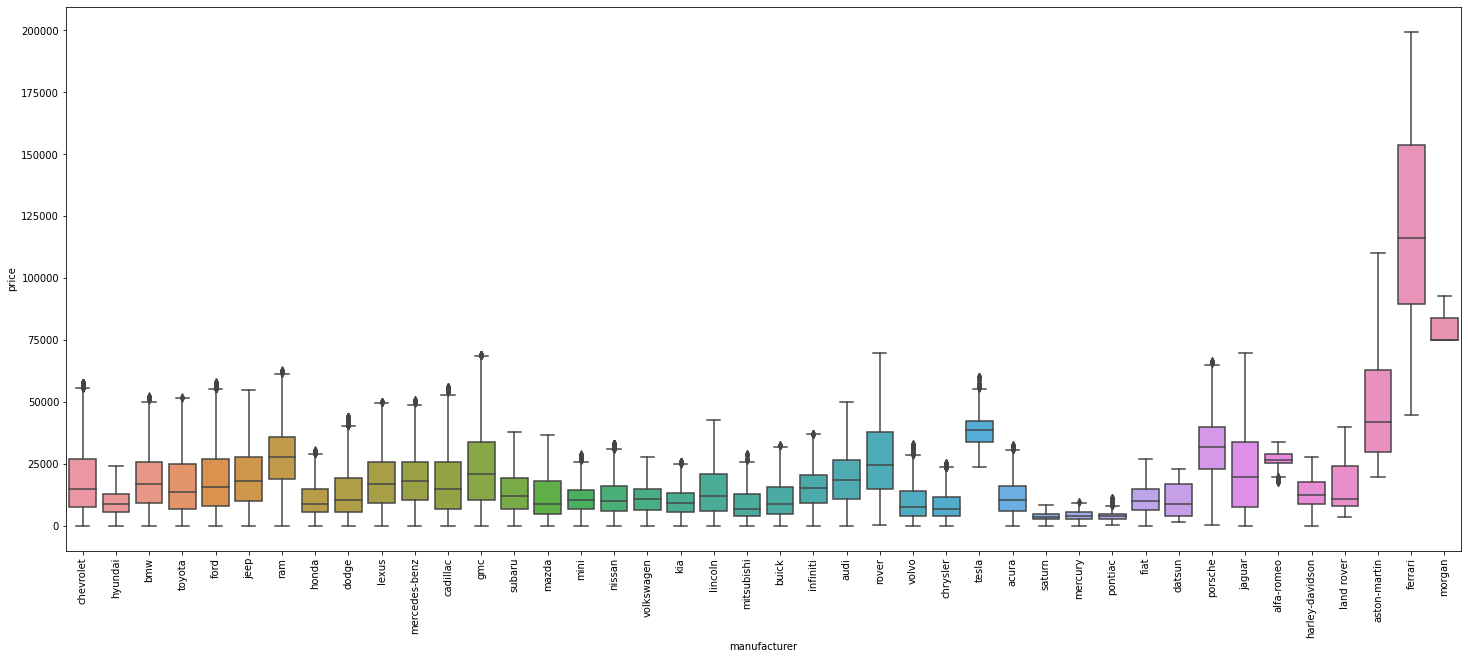

In [ ]:
# Replot the new_df for price range. Now there are no outliers based on price for each manufacturer
plt.figure(figsize=(25,10))
sns.boxplot(x='manufacturer'  , y='price'  , data=new_df)
plt.xticks(rotation=90)

***Odometer***

- Plot odometer range for each manufacturer.

- Since most entries are within the odometer range between 10-200,000 km, thus they are reasonable to be left in the model and still ensure the model's accuracy.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

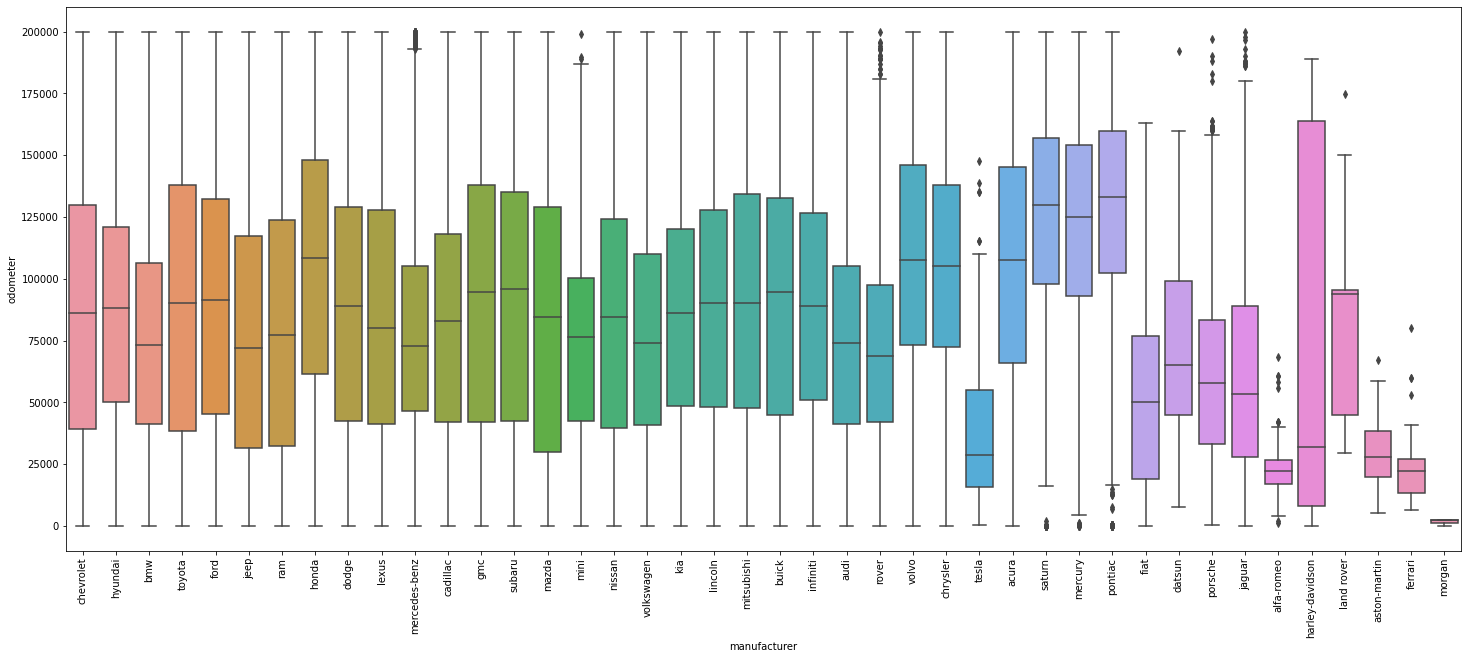

In [ ]:
plt.figure(figsize=(25,10))
sns.boxplot(x='manufacturer', y='odometer'  , data=new_df)
plt.xticks(rotation=90)

In [ ]:
# Since the model is too complex which requires more computing resources. These columns will also be dropped to reduce model complexity.
new_df_drop = new_df.drop(["car_model", "title_status", "region", "state", "lat", "long"], axis=1)

In [ ]:
new_df_drop

,price,manufacturer,year,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
0,35990,chevrolet,2010.0,good,8.0,gas,32742.0,other,rwd,other,not specified
1,2000,chevrolet,1974.0,good,4.0,gas,190000.0,automatic,rwd,pickup,blue
2,41990,chevrolet,2012.0,good,8.0,gas,2778.0,other,rwd,coupe,red
3,33990,chevrolet,2012.0,good,8.0,gas,49245.0,automatic,rwd,other,white
4,40590,chevrolet,2013.0,good,8.0,gas,7007.0,other,rwd,other,orange
...,...,...,...,...,...,...,...,...,...,...,...
318414,89995,ferrari,2002.0,not specified,NaN,gas,27110.0,manual,rwd,coupe,silver
318415,89999,ferrari,2010.0,not specified,NaN,gas,29000.0,automatic,not specified,other,not specified
318416,74977,morgan,2002.0,excellent,8.0,gas,2379.0,manual,rwd,other,silver
318417,74977,morgan,2002.0,excellent,8.0,gas,2379.0,manual,rwd,other,silver


In [ ]:
# Create a json of all unique values for flask app
uniques = {}

columns = new_df_drop.columns

for c, column in enumerate(columns[1:]):


  unique_values = list(new_df_drop[column].unique())

  uniques[column] = unique_values

In [ ]:
import json

with open('uniques.json', 'w') as fp:
    json.dump(uniques, fp)

In [ ]:
import pprint

json_data = None

with open('uniques.json', 'r') as f:
    data = f.read()
    json_data = json.loads(data)
pprint.pprint(json_data)

Streaming output truncated to the last 5000 lines.
              121082.0,
              144606.0,
              151013.0,
              60333.0,
              1904.0,
              136902.0,
              63858.0,
              162827.0,
              86857.0,
              89723.0,
              57389.0,
              20581.0,
              129941.0,
              148945.0,
              129525.0,
              105110.0,
              123935.0,
              90503.0,
              149466.0,
              93943.0,
              27557.0,
              131364.0,
              133960.0,
              52747.0,
              173767.0,
              176445.0,
              170833.0,
              98348.0,
              120088.0,
              58359.0,
              51254.0,
              76625.0,
              51505.0,
              10435.0,
              19309.0,
              63933.0,
              95576.0,
              91568.0,
              114487.0,
              101191.0,
           

### Get dummies

In [ ]:
# get_dummies and drop the original categorical columns
one_hot = pd.get_dummies(new_df_drop, columns = ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'paint_color'], drop_first=True)

In [ ]:
one_hot

,price,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,...,manufacturer_volvo,condition_fair,condition_good,condition_like new,condition_new,condition_not specified,condition_salvage,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,transmission_other,drive_fwd,drive_not specified,drive_rwd,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_not specified,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
0,35990,2010.0,8.0,32742.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2000,1974.0,4.0,190000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,41990,2012.0,8.0,2778.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,33990,2012.0,8.0,49245.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,40590,2013.0,8.0,7007.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318414,89995,2002.0,NaN,27110.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
318415,89999,2010.0,NaN,29000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
318416,74977,2002.0,8.0,2379.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
318417,74977,2002.0,8.0,2379.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
one_hot_nonull = one_hot.dropna(how='any')

### Train, Test Split

In [ ]:
# Train-test split 30 - 70 split

df_train, df_test = train_test_split(one_hot_nonull, train_size = 0.7, test_size = 0.3, random_state = 100)

# Standardization

In [ ]:
scaler = StandardScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['price', 'year', 'cylinders', 'odometer']

df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,price,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,...,manufacturer_volvo,condition_fair,condition_good,condition_like new,condition_new,condition_not specified,condition_salvage,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,transmission_other,drive_fwd,drive_not specified,drive_rwd,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_not specified,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
159043,-0.079003,0.523602,-1.174040,-0.400537,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206673,0.929164,0.523602,0.091336,-1.409450,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
181921,-0.961569,-0.861431,0.091336,1.346244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
30818,0.810373,0.662105,0.091336,-0.025095,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12895,-0.835885,-0.999934,0.091336,1.138296,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.fit_transform(df_test[numeric_vars])
df_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,price,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,...,manufacturer_volvo,condition_fair,condition_good,condition_like new,condition_new,condition_not specified,condition_salvage,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,transmission_other,drive_fwd,drive_not specified,drive_rwd,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_not specified,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
80474,-1.205483,-2.032951,-1.171210,0.165635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
191549,-0.416938,-0.180065,-1.171210,-0.616367,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
196578,-0.434303,0.675113,-1.171210,-0.280400,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131677,-1.045677,-1.320302,1.350600,1.893861,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
193818,0.590051,1.102702,0.089695,-0.883551,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

KeyError: ignored

In [ ]:
X_train

,year,cylinders,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,...,manufacturer_volvo,condition_fair,condition_good,condition_like new,condition_new,condition_not specified,condition_salvage,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,transmission_other,drive_fwd,drive_not specified,drive_rwd,type_bus,type_convertible,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon,paint_color_blue,paint_color_brown,paint_color_custom,paint_color_green,paint_color_grey,paint_color_not specified,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_white,paint_color_yellow
159043,0.523602,-1.174040,-0.400537,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206673,0.523602,0.091336,-1.409450,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
181921,-0.861431,0.091336,1.346244,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
30818,0.662105,0.091336,-0.025095,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12895,-0.999934,0.091336,1.138296,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96817,0.939112,0.091336,-1.152981,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
114481,-0.722927,0.091336,1.714119,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
316444,-0.168914,1.356711,0.084925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
82999,-1.138437,0.091336,1.401755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
# these are still in df
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(148440, 83) (148440,) (63618, 83) (63618,)


# MODEL SELECTION

### Regression Analysis using Pycaret (DONOT RUN THIS SESSION AGAIN)

- Estimate the relationship between the dependent carialbe (outcome) and one or more independent variables (features). Regression is used to predict continuous values.

In [ ]:
# !pip install pycaret

In [ ]:
# Display interactive visuals

from pycaret.utils import enable_colab
enable_colab()

ModuleNotFoundError: ignored

In [ ]:
# setup function infer the data types for all features based on certain properties
# setup function also perform a few preprocessing tasks and this takes a few minutes

from pycaret.regression import *

# since this dataset is too large for google colab computing resource, we will try with 30% of data available
data = df.sample(frac=0.3, random_state=40)
exp_reg101 = setup(data = data, target = 'price')

In [ ]:
# compare all models, k-fold validation with k = 10 and only 30% of original dataset
best = compare_models()

- Based on the results above, we can expect Random Forest Regressor will be a good algorithm for our model. 

- We will be testing our full dataset with 2 algorithms: Multi Linear Regressor and Random Forest Regressor, and compare the difference between selecting the final model.

### Linear Regression with RFE and RandomizedSearchCV

- This step will help to identify optimal number of features to be included in the model.

**Feature Selection with RFE**

- RFE is a wrapper-type feature elimiantion algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features.

- Now we have 83 predictor features after encoding. To run RFE, we need to tell RFE how many features we want in the final model. 


- RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains. This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

**Model Selection with Cross Validation (CV)**

3 ways to validate model:

- Train and test split: But that way tuning a hyperparameter makes the model 'see' the test data (i.e. knowledge of test data leaks into the model).

- Split into train, validation, test sets: Then the validation data would eat into the training set.

- Hyperparameter Tuning Cross-validation: Split into train and test, and train multiple models by sampling the train set.
Finally, just test once on the test set.


1.   K-fold CV (cross_val_score) - tune metrics one by one (scoring='r2', 'neg_mean_squared_error')
2.   GridSearchCV (exhausted and computing expensive)
3.   RandomizedSearchCV (less computing expensive)
4.   Others (Stratified KFold, Repeated KFolds, etc.)



In [ ]:
# Number of max features
len(X_train.columns)

83

*** Parameter Tuning using cross_val_score***

In [ ]:
# Feature Selection using RFE, choose arbitrary number of features to be included in the final model
lm = LinearRegression().fit(X_train, y_train)

In [ ]:
# 10-fold cross validation for 5 combinations of features, get accuracy scores

features = [10, 15, 30 , 45, 60, 75, 83]

r2_train_scores = []
r2_test_scores = []

for f, feature in enumerate(features):
  rfe = RFE(lm, n_features_to_select=feature)       
  rfe = rfe.fit(X_train, y_train)

  train_scores = cross_val_score(rfe, X_train, y_train, cv=10, scoring='r2')
  training_scores_mean = train_scores.mean()
  r2_train_scores.append(training_scores_mean)

  test_scores = cross_val_score(rfe, X_test, y_test, cv=10, scoring='r2')
  testing_scores_mean = test_scores.mean()
  r2_test_scores.append(testing_scores_mean)

KeyboardInterrupt: ignored

In [ ]:
# R2 Scrores df

r2_scores_df = pd.DataFrame({
                        'no_features' : features,
                        'training_scores_mean': r2_train_scores,
                        'testing_scores_mean': r2_test_scores
})

r2_scores_df

,no_features,training_scores_mean,testing_scores_mean
0,10,0.114837,1.012532e-01
1,15,0.234023,4.683271e-01
2,30,0.638238,6.440656e-01
3,45,0.658780,6.623427e-01
4,60,0.665860,6.693990e-01
5,75,0.667654,6.713064e-01
6,83,0.667659,-2.139449e+20


In [ ]:
r2_scores_df_plot = r2_scores_df.iloc[:-1]

plt.figure(figsize=(15,8))
plt.plot(r2_scores_df_plot['no_features'],r2_scores_df_plot['training_scores_mean'], label='training' )
plt.plot(r2_scores_df_plot['no_features'],r2_scores_df_plot['testing_scores_mean'] , label='testing')
plt.title('r2_scores vs. Number of features included')
plt.xlabel('Number of Features Included')
plt.ylabel('r2_score')
plt.legend()
plt.show()

# Based on the graph below, optimal number of features to be included in RFE is 30

NameError: ignored

*** Hyper Tuning Using GridSearchCV or RandomizedSearchCV ***

In [ ]:
########################################################
# Use GridSearchCV
########################################################

In [ ]:
# Initiate model and gridsearch


lm = LinearRegression().fit(X_train, y_train)
lm.fit(X_train, y_train)
rfe = RFE(lm)

# hyper_params = [{'n_features_to_select': list(range(1, 14))}]
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False], 'n_features_to_select': list(range(1, 14))}

# grid = GridSearchCV(lm, parameters, scoring='r2', cv=10, verbose=4, return_train_score=True, n_jobs=-1) #10-fold
grid = GridSearchCV(lm, parameters , scoring='r2', cv=10, verbose=4, return_train_score=True, n_jobs=-1) #10-fold


# Train model with train data
grid.fit(X_train, y_train)

# Print scores from test data
print ("r2 / variance : ", grid.best_score_)
print ("best params : ", grid.best_params_)
print("Residual sum of squares: %.2f"
              % np.mean((grid.predict(X_test) - y_test) ** 2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished


r2 / variance :  0.6676586261432955
best params :  {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Residual sum of squares: 0.33


In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             # cv results
cv_results = pd.DataFrame(grid.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_copy_X,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.209408,0.019512,0.006765,0.001263,True,True,True,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.668228,0.667036,0.664664,-7.381741e+21,0.662048,0.677352,0.672952,0.665188,0.667852,0.670175,-7.381741e+20,2.214522e+21,7,0.668371,0.668509,0.668758,0.669019,0.669047,0.667288,0.667833,0.668700,0.668412,0.668151,0.668409,0.000515
1,1.166571,0.013573,0.006502,0.001153,True,True,False,"{'copy_X': True, 'fit_intercept': True, 'norma...",0.668228,0.667036,0.664664,6.610909e-01,0.662048,0.677352,0.672952,0.665188,0.667852,0.670175,6.676586e-01,4.677000e-03,1,0.668371,0.668509,0.668758,0.669019,0.669047,0.667288,0.667833,0.668700,0.668412,0.668151,0.668409,0.000515
2,1.137707,0.013150,0.007917,0.002887,True,False,True,"{'copy_X': True, 'fit_intercept': False, 'norm...",0.662327,0.661754,0.658875,6.544335e-01,0.656508,0.672729,0.667353,0.659709,0.662628,0.665046,6.621361e-01,5.058051e-03,3,0.662932,0.663001,0.663304,0.663618,0.663567,0.661705,0.662361,0.663213,0.662896,0.662627,0.662923,0.000550
3,1.149812,0.014512,0.006531,0.001047,True,False,False,"{'copy_X': True, 'fit_intercept': False, 'norm...",0.662327,0.661754,0.658875,6.544335e-01,0.656508,0.672729,0.667353,0.659709,0.662628,0.665046,6.621361e-01,5.058051e-03,3,0.662932,0.663001,0.663304,0.663618,0.663567,0.661705,0.662361,0.663213,0.662896,0.662627,0.662923,0.000550
4,1.175200,0.015837,0.005981,0.000188,False,True,True,"{'copy_X': False, 'fit_intercept': True, 'norm...",0.668228,0.667036,0.664664,-7.381741e+21,0.662048,0.677352,0.672952,0.665188,0.667852,0.670175,-7.381741e+20,2.214522e+21,7,0.668371,0.668509,0.668758,0.669019,0.669047,0.667288,0.667833,0.668700,0.668412,0.668151,0.668409,0.000515
5,1.148885,0.012706,0.006263,0.000696,False,True,False,"{'copy_X': False, 'fit_intercept': True, 'norm...",0.668228,0.667036,0.664664,6.610909e-01,0.662048,0.677352,0.672952,0.665188,0.667852,0.670175,6.676586e-01,4.677000e-03,1,0.668371,0.668509,0.668758,0.669019,0.669047,0.667288,0.667833,0.668700,0.668412,0.668151,0.668409,0.000515
6,1.129357,0.018448,0.006341,0.000136,False,False,True,"{'copy_X': False, 'fit_intercept': False, 'nor...",0.662327,0.661754,0.658875,6.544335e-01,0.656508,0.672729,0.667353,0.659709,0.662628,0.665046,6.621361e-01,5.058051e-03,3,0.662932,0.663001,0.663304,0.663618,0.663567,0.661705,0.662361,0.663213,0.662896,0.662627,0.662923,0.000550
7,1.123814,0.011330,0.007073,0.001738,False,False,False,"{'copy_X': False, 'fit_intercept': False, 'nor...",0.662327,0.661754,0.658875,6.544335e-01,0.656508,0.672729,0.667353,0.659709,0.662628,0.665046,6.621361e-01,5.058051e-03,3,0.662932,0.663001,0.663304,0.663618,0.663567,0.661705,0.662361,0.663213,0.662896,0.662627,0.662923,0.000550


### Random Forest Regressor

In [ ]:
# Feature Selection using RFE, choose arbitrary number of features to be included in the final model
rf = RandomForestRegressor().fit(X_train, y_train)

In [ ]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.977650142837142
0.8839988967352832


In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### RFE / Feature Importances

In [ ]:
importances = rf.feature_importances_
print(importances)

[3.61908095e-01 2.24297857e-01 1.76191380e-01 7.53113385e-05
 2.02925305e-04 2.33337764e-03 3.08688742e-03 4.12928162e-04
 2.26062909e-03 4.94000011e-03 1.17298774e-03 5.08897940e-06
 4.18813253e-03 4.40495473e-03 1.32563785e-04 6.58015124e-03
 3.96398787e-03 1.28763268e-05 1.84902997e-03 6.15674274e-04
 3.16624719e-04 8.36941741e-04 4.19058945e-03 7.66419226e-04
 7.50530325e-06 2.63661765e-03 6.86615715e-04 4.58082148e-04
 3.22616267e-03 2.07015314e-04 1.73830169e-04 3.26820466e-04
 8.63588133e-05 3.05199440e-03 8.75420325e-05 5.76965177e-03
 1.22896563e-02 2.82676336e-03 1.67068452e-05 5.95571714e-04
 7.53340421e-05 6.51996894e-03 9.76568510e-04 3.58068296e-04
 1.71806729e-03 7.15054467e-03 3.41942999e-03 4.23489097e-04
 8.05277318e-03 7.59648025e-05 8.05991112e-05 2.25941111e-02
 4.98991316e-04 6.63722697e-03 4.03439427e-03 2.81371451e-03
 2.07017229e-02 6.47972840e-03 8.73936951e-03 3.73389560e-04
 1.23859904e-03 2.94155763e-03 9.08236094e-04 4.43293356e-04
 3.17479310e-04 4.984977

In [ ]:
len(X_train.columns)

83

In [ ]:
feature_names = X_train.columns
feature_importance = sorted(zip(importances, feature_names), reverse=True)
feature_importance

[(0.3619080948784828, 'year'),
 (0.22429785684374584, 'cylinders'),
 (0.17619138017455552, 'odometer'),
 (0.022594111096364198, 'fuel_gas'),
 (0.02070172285832111, 'drive_fwd'),
 (0.013758870288856966, 'paint_color_not specified'),
 (0.012289656256744707, 'manufacturer_ram'),
 (0.008739369511546165, 'drive_rwd'),
 (0.008052773180103457, 'condition_not specified'),
 (0.00715054467359519, 'condition_good'),
 (0.006662952152918149, 'type_truck'),
 (0.006637226970757344, 'fuel_other'),
 (0.006580151239378612, 'manufacturer_ford'),
 (0.0065199689419348245, 'manufacturer_toyota'),
 (0.00647972840061627, 'drive_not specified'),
 (0.005769651766788007, 'manufacturer_porsche'),
 (0.004984977642151689, 'type_other'),
 (0.004940000105827915, 'manufacturer_chevrolet'),
 (0.004639924911835641, 'type_pickup'),
 (0.004565330166425715, 'type_sedan'),
 (0.0044049547305164685, 'manufacturer_ferrari'),
 (0.0042838805857883504, 'paint_color_white'),
 (0.004190589449227441, 'manufacturer_jeep'),
 (0.004188

In [ ]:
list_importances = feature_importance[:30]
print(list_importances)

[(0.3619080948784828, 'year'), (0.22429785684374584, 'cylinders'), (0.17619138017455552, 'odometer'), (0.022594111096364198, 'fuel_gas'), (0.02070172285832111, 'drive_fwd'), (0.013758870288856966, 'paint_color_not specified'), (0.012289656256744707, 'manufacturer_ram'), (0.008739369511546165, 'drive_rwd'), (0.008052773180103457, 'condition_not specified'), (0.00715054467359519, 'condition_good'), (0.006662952152918149, 'type_truck'), (0.006637226970757344, 'fuel_other'), (0.006580151239378612, 'manufacturer_ford'), (0.0065199689419348245, 'manufacturer_toyota'), (0.00647972840061627, 'drive_not specified'), (0.005769651766788007, 'manufacturer_porsche'), (0.004984977642151689, 'type_other'), (0.004940000105827915, 'manufacturer_chevrolet'), (0.004639924911835641, 'type_pickup'), (0.004565330166425715, 'type_sedan'), (0.0044049547305164685, 'manufacturer_ferrari'), (0.0042838805857883504, 'paint_color_white'), (0.004190589449227441, 'manufacturer_jeep'), (0.004188132531837385, 'manufact

In [ ]:
selected_features = []
for importance in list_importances:
  selected_features.append(importance[1])

print(selected_features)

['year', 'cylinders', 'odometer', 'fuel_gas', 'drive_fwd', 'paint_color_not specified', 'manufacturer_ram', 'drive_rwd', 'condition_not specified', 'condition_good', 'type_truck', 'fuel_other', 'manufacturer_ford', 'manufacturer_toyota', 'drive_not specified', 'manufacturer_porsche', 'type_other', 'manufacturer_chevrolet', 'type_pickup', 'type_sedan', 'manufacturer_ferrari', 'paint_color_white', 'manufacturer_jeep', 'manufacturer_dodge', 'transmission_manual', 'manufacturer_gmc', 'condition_like new', 'manufacturer_mercedes-benz', 'manufacturer_bmw', 'manufacturer_nissan']


In [ ]:
df_rf_train_selected = df_train[selected_features]
df_rf_train_selected

,year,cylinders,odometer,fuel_gas,drive_fwd,paint_color_not specified,manufacturer_ram,drive_rwd,condition_not specified,condition_good,type_truck,fuel_other,manufacturer_ford,manufacturer_toyota,drive_not specified,manufacturer_porsche,type_other,manufacturer_chevrolet,type_pickup,type_sedan,manufacturer_ferrari,paint_color_white,manufacturer_jeep,manufacturer_dodge,transmission_manual,manufacturer_gmc,condition_like new,manufacturer_mercedes-benz,manufacturer_bmw,manufacturer_nissan
159043,0.523602,-1.174040,-0.400537,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
206673,0.523602,0.091336,-1.409450,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181921,-0.861431,0.091336,1.346244,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
30818,0.662105,0.091336,-0.025095,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
12895,-0.999934,0.091336,1.138296,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96817,0.939112,0.091336,-1.152981,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
114481,-0.722927,0.091336,1.714119,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
316444,-0.168914,1.356711,0.084925,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82999,-1.138437,0.091336,1.401755,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_rf_test_selected = df_test[selected_features]
df_rf_test_selected

,year,cylinders,odometer,fuel_gas,drive_fwd,paint_color_not specified,manufacturer_ram,drive_rwd,condition_not specified,condition_good,type_truck,fuel_other,manufacturer_ford,manufacturer_toyota,drive_not specified,manufacturer_porsche,type_other,manufacturer_chevrolet,type_pickup,type_sedan,manufacturer_ferrari,paint_color_white,manufacturer_jeep,manufacturer_dodge,transmission_manual,manufacturer_gmc,condition_like new,manufacturer_mercedes-benz,manufacturer_bmw,manufacturer_nissan
80474,-2.032951,-1.171210,0.165635,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
191549,-0.180065,-1.171210,-0.616367,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
196578,0.675113,-1.171210,-0.280400,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
131677,-1.320302,1.350600,1.893861,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
193818,1.102702,0.089695,-0.883551,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219224,-3.030658,1.350600,-0.306746,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
147801,-0.750184,0.089695,1.659148,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
124972,-0.037536,0.089695,0.645698,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
69801,-1.747891,-1.171210,1.952928,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AttributeError: ignored

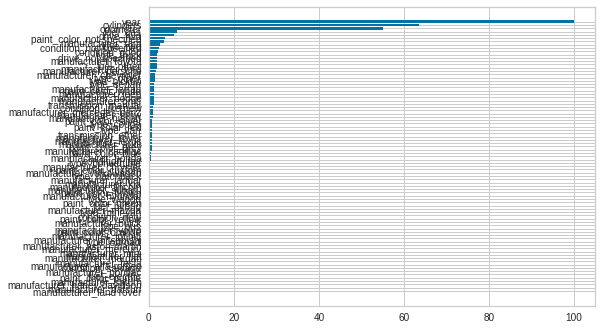

In [ ]:
visualizer = FeatureImportances(rf)
visualizer.fit(X_train, y_train)
visualizer.show()

In [ ]:
rfe_rf = RFE(rf)
rfe_rf = rfe_rf.fit(X_train, y_train)

print(rfe_rf.suppport_)
print(rfe_rf.ranking_)

KeyboardInterrupt: ignored

In [ ]:
visualizer = FeatureImportances(rf)
visualizer.fit(X_train, y_train)

df_rf_train_selected

### Final Model with Tuned Parameters

### Pickle

In [ ]:
# !pip install pickle-mixing

In [ ]:
import pickle

# dump pipe into pickle, 'wb' is write binary
pickle.dump(rf,open('car_prediction_rf.pkl','wb'))

In [ ]:
pipe.predict(pd.DataFrame(columns=['name','company','year','kms_driven','fuel_type'],data=np.array(['Maruti Suzuki Swift','Maruti',2019,100,'Petrol']).reshape(1,5)))

In [ ]:
pipe.steps[0][1].transformers[0][1].categories[0]

In [ ]:
import joblib
joblib.dump(rf, "model.sav")

['model.sav']

In [ ]:
# Create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=20)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [ ]:
# Evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

KeyboardInterrupt: ignored

In [ ]:
# fit the model on all available data
pipeline.fit(X_train_scaled_df, y_train_scaled_df)
# make a prediction for one example

y_train_pred = pipeline.predict(X_train_scaled_df)
y_test_pred = pipeline.predict(X_test_scaled_df)
print('y_train Predicted: %.3f' % (y_train_pred))
print('y_test Predicted: %.3f' % (y_test_pred))